In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
pwd()

'/Users/gabegm/code/bike-sharing/notebooks'

In [29]:
import pandas as pd
import numpy as np
from datetime import timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
plt.style.use("ggplot")

In [50]:
# read raw data
df_all = pd.read_csv("../data/raw/day.csv")
df_all.loc[:, "dteday"] = pd.to_datetime(df_all["dteday"])
df_all.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [51]:
# split dataset
df_last30 = df_all.tail(30)
df = df_all.iloc[:-30, :]

df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- holiday : weather day is holiday or not (extracted from )
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0. + weathersit :
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale) - hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

## Tidying

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     701 non-null    int64         
 1   dteday      701 non-null    datetime64[ns]
 2   season      701 non-null    int64         
 3   yr          701 non-null    int64         
 4   mnth        701 non-null    int64         
 5   holiday     701 non-null    int64         
 6   weekday     701 non-null    int64         
 7   workingday  701 non-null    int64         
 8   weathersit  701 non-null    int64         
 9   temp        701 non-null    float64       
 10  atemp       701 non-null    float64       
 11  hum         701 non-null    float64       
 12  windspeed   701 non-null    float64       
 13  casual      701 non-null    int64         
 14  registered  701 non-null    int64         
 15  cnt         701 non-null    int64         
dtypes: datetime64[ns](1), floa

In [53]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,351.000000,2.479315,0.479315,6.285307,0.028531,3.004280,0.684736,1.385164,0.502732,0.480847,0.625717,0.190534,866.937233,3661.104137,4528.041369
std,202.505555,1.090839,0.499929,3.329294,0.166602,2.003207,0.464953,0.542489,0.182781,0.162584,0.141988,0.076740,693.470674,1553.467783,1939.766889
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,176.000000,2.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.343478,0.348470,0.519167,0.134958,317.000000,2507.000000,3194.000000
50%,351.000000,2.000000,0.000000,6.000000,0.000000,3.000000,1.000000,1.000000,0.514167,0.503146,0.623750,0.182221,738.000000,3656.000000,4541.000000
75%,526.000000,3.000000,1.000000,9.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.613025,0.728750,0.233221,1135.000000,4739.000000,6041.000000
max,701.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [54]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [55]:
d = df["dteday"].to_list()
date_set = set(d[0] + timedelta(x) for x in range((d[-1] - d[0]).days))
missing = sorted(date_set - set(d))
print(missing)

[]


In [57]:
df.loc[:, "temp_pct_change"] = df["temp"].pct_change().round(2)
df.loc[:, "atemp_pct_change"] = df["atemp"].pct_change().round(2)
df.loc[:, "hum_pct_change"] = df["hum"].pct_change().round(2)
df.loc[:, "windspeed_pct_change"] = df["windspeed"].pct_change().round(2)
df.loc[:, "casual_pct_change"] = df["casual"].pct_change().round(2)
df.loc[:, "registered_pct_change"] = df["registered"].pct_change().round(2)
df.loc[:, "cnt_pct_change"] = df["cnt"].pct_change().round(2)
df.head()

/var/folders/01/6f4gt1vx3n52bjqc48_xychc0000gn/T/ipykernel_38157/2884088609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "temp_pct_change"] = df["temp"].pct_change().round(2)
/var/folders/01/6f4gt1vx3n52bjqc48_xychc0000gn/T/ipykernel_38157/2884088609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "atemp_pct_change"] = df["atemp"].pct_change().round(2)
/var/folders/01/6f4gt1vx3n52bjqc48_xychc0000gn/T/ipykernel_38157/2884088609.py:3: SettingWithCopyWarning: 
A value is trying t

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,casual,registered,cnt,temp_pct_change,atemp_pct_change,hum_pct_change,windspeed_pct_change,casual_pct_change,registered_pct_change,cnt_pct_change
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,...,331,654,985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,131,670,801,0.06,-0.03,-0.14,0.55,-0.60,0.02,-0.19
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,120,1229,1349,-0.46,-0.46,-0.37,-0.00,-0.08,0.83,0.68
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,108,1454,1562,0.02,0.12,0.35,-0.35,-0.10,0.18,0.16
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,82,1518,1600,0.13,0.08,-0.26,0.17,-0.24,0.04,0.02


In [43]:
df[df["cnt_pct_change"] > 10]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,hum,windspeed,casual,registered,cnt,nmax,n95,pct_diff,pct_change,cnt_pct_change
668,669,2012-10-30,4,1,10,0,2,1,2,0.318182,...,0.825455,0.213009,87,1009,1096,91.33,86.77,48.82,48.82,48.82


## Visualisation

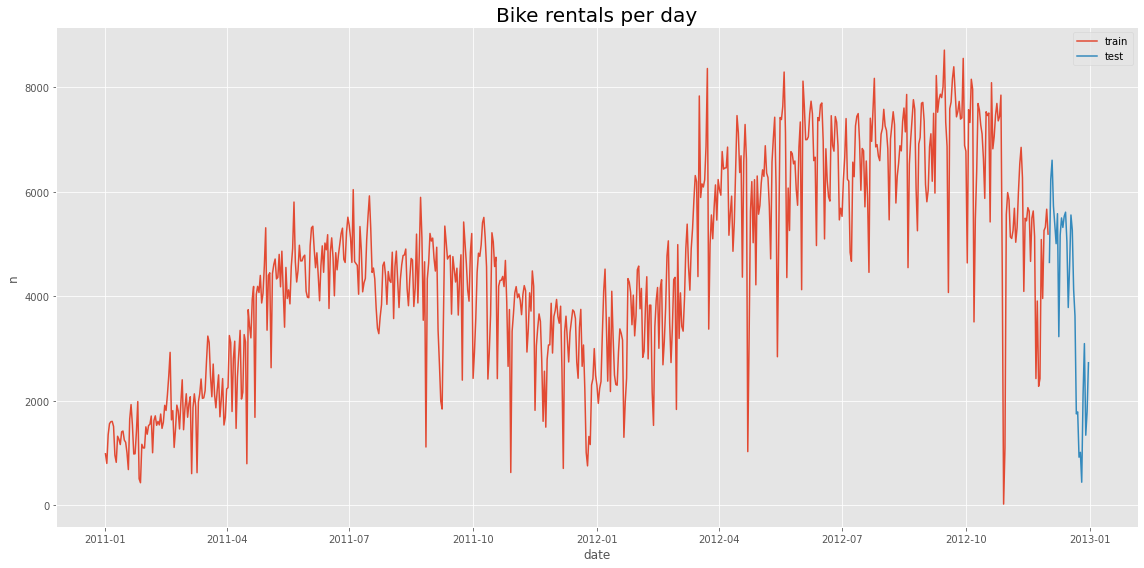

In [44]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title("Bike rentals per day", fontsize=20, fontweight=3)
ax.set(xlabel="date", ylabel="n")
sns.lineplot(x="dteday", y="cnt", data=df, label="train", ax=ax)
sns.lineplot(x="dteday", y="cnt", data=df_last30, label="test", ax=ax)
ax.legend()
fig.tight_layout()
fig.savefig("../figures/bike-rentals-per-day.png")

/Users/gabegm/pyenvs/bike-sharing/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


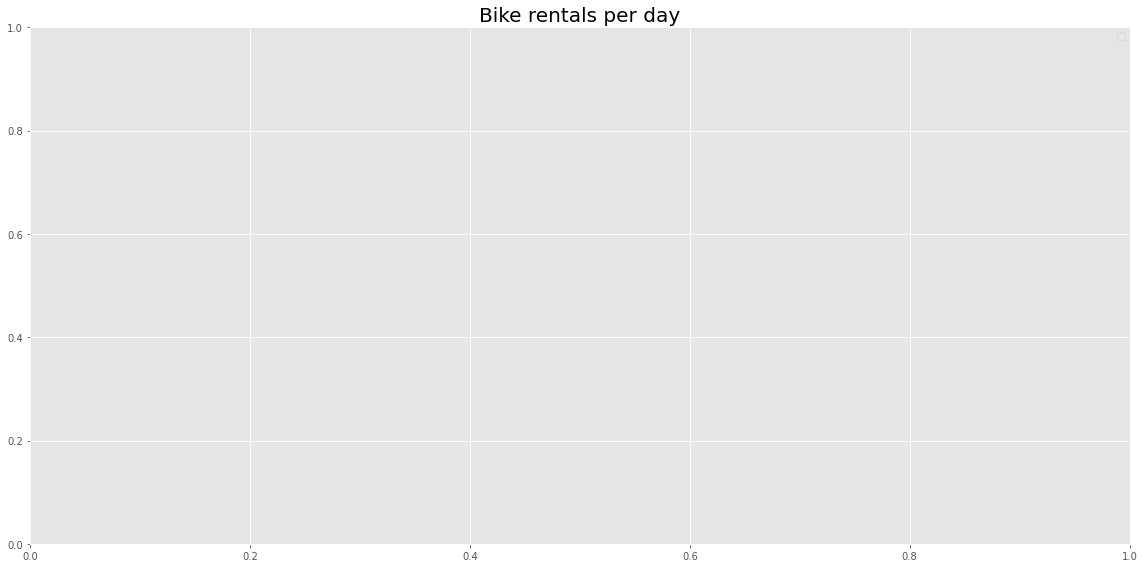

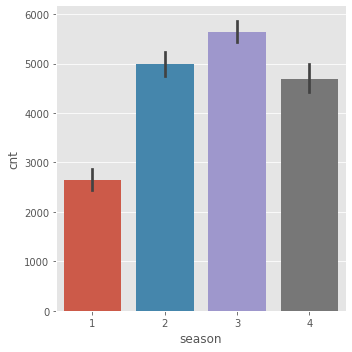

In [64]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title("Bike rentals per day", fontsize=20, fontweight=3)
#ax.set(xlabel="date", ylabel="n")
sns.catplot(x="season", y="cnt", kind="bar", data=df, ax=ax)
ax.legend()
fig.tight_layout()
fig.savefig("../figures/bike-rentals-per-season.png")

AttributeError: 'NoneType' object has no attribute 'set_title'

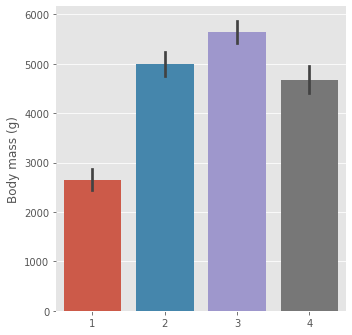

In [61]:
g = sns.catplot(
    data=df,
    kind="bar",
    x="season",
    y="cnt"
)
g.despine(left=True)
g.set_axis_labels("", "season")
g.legend.set_title("")

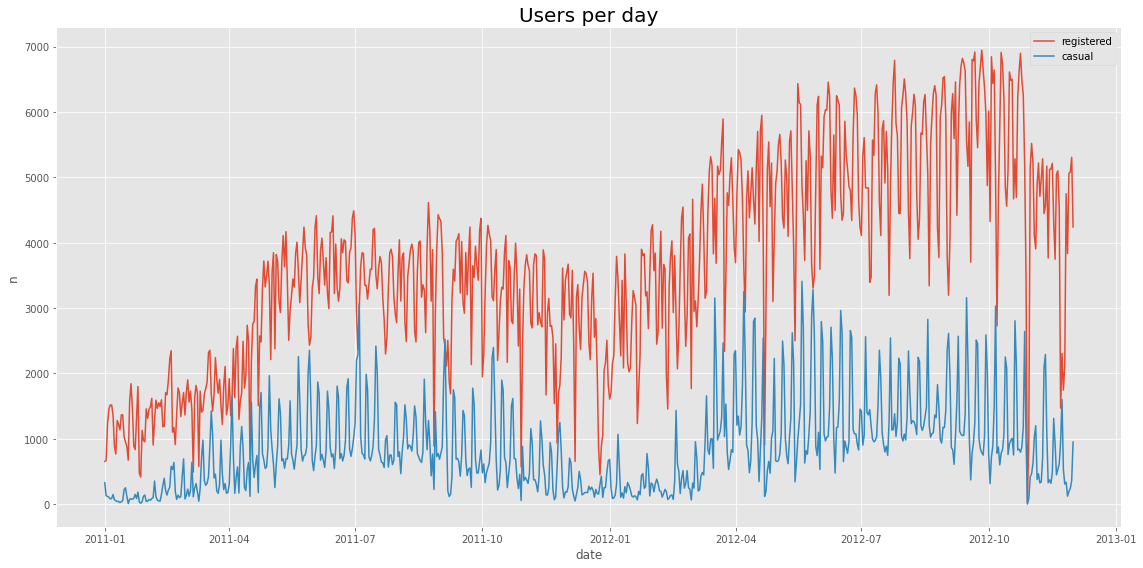

In [47]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title("Users per day", fontsize=20, fontweight=3)
ax.set(xlabel="date", ylabel="n")
sns.lineplot(x="dteday", y="registered", label="registered", data=df, ax=ax)
sns.lineplot(x="dteday", y="casual", data=df, label="casual", ax=ax)
ax.legend()
fig.tight_layout()
fig.savefig("../figures/users-per-day.png")

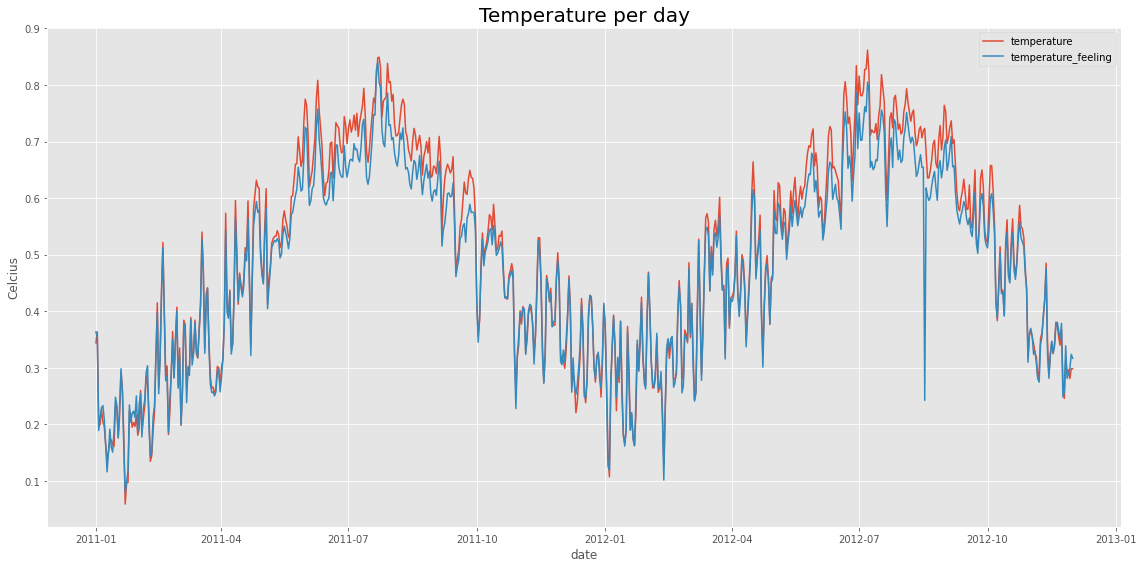

In [49]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title("Temperature per day", fontsize=20, fontweight=3)
ax.set(xlabel="date", ylabel="Celcius")
sns.lineplot(x="dteday", y="temp", label="temperature", data=df, ax=ax)
sns.lineplot(x="dteday", y="atemp", data=df, label="temperature_feeling", ax=ax)
ax.legend()
fig.tight_layout()
fig.savefig("../figures/temp-per-day.png")

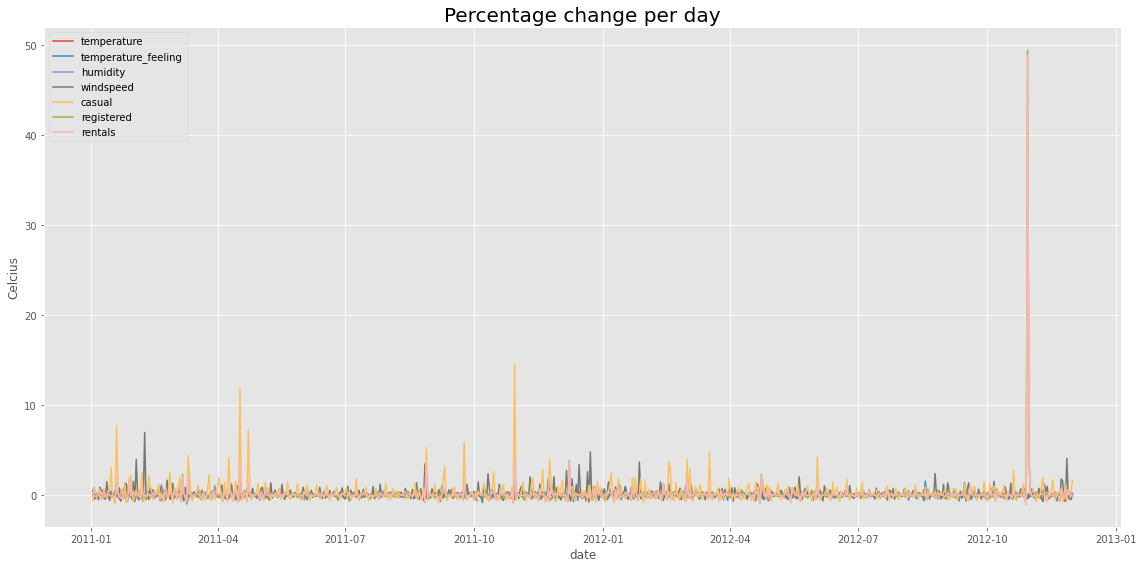

In [58]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title("Percentage change per day", fontsize=20, fontweight=3)
ax.set(xlabel="date", ylabel="Celcius")
sns.lineplot(x="dteday", y="temp_pct_change", label="temperature", data=df, ax=ax)
sns.lineplot(x="dteday", y="atemp_pct_change", data=df, label="temperature_feeling", ax=ax)
sns.lineplot(x="dteday", y="hum_pct_change", label="humidity", data=df, ax=ax)
sns.lineplot(x="dteday", y="windspeed_pct_change", data=df, label="windspeed", ax=ax)
sns.lineplot(x="dteday", y="casual_pct_change", label="casual", data=df, ax=ax)
sns.lineplot(x="dteday", y="registered_pct_change", data=df, label="registered", ax=ax)
sns.lineplot(x="dteday", y="cnt_pct_change", data=df, label="rentals", ax=ax)
ax.legend()
fig.tight_layout()
fig.savefig("../figures/pct_change-per-day.png")

In [27]:
# each bike has exactly maximum 12 rentals per day
df.loc[:, "nmax"] = np.around(df["cnt"] / 12, 2)
# 95% of rentals
df.loc[:, "n95"] =  np.around((df["cnt"] / 12) * .95, 2)
df.head()

/var/folders/01/6f4gt1vx3n52bjqc48_xychc0000gn/T/ipykernel_38157/1276139079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["nmax"] = np.around(df["cnt"] / 12, 2)
/var/folders/01/6f4gt1vx3n52bjqc48_xychc0000gn/T/ipykernel_38157/1276139079.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["n95"] =  np.around((df["cnt"] / 12) * .95, 2)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,nmax,n95
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,82.08,77.98
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,66.75,63.41
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,112.42,106.80
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,130.17,123.66
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,133.33,126.67


In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title("Bike rentals per day", fontsize=20, fontweight=3)
ax.set(xlabel="date", ylabel="n")
#sns.lineplot(x="dteday", y="cnt", data=df, label="train", ax=ax)
#sns.lineplot(x="dteday", y="cnt", data=df_last30, label="test", ax=ax)
#sns.displot(data=df)
sns.kdeplot(x="nmax", data=df, label="nmax")
sns.kdeplot(x="n95", data=df, label="n95")
ax.legend()
fig.tight_layout()
fig.savefig("../figures/.png")

Model

In [ ]:
X = df[""]
y = df["cnt"]

In [ ]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
print(regr)

In [ ]:
regr.fit(X, y)
print(regr.predict([[0, 0, 0, 0]]))